In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
SD = 0.05 * (0.8 ** 7) # -4 ... 10 
print('SD:', SD)

SD: 0.010485760000000004


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'ATVI', 'AXON', 'AYX', 
    'BILI', 'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 
    'ELIO', 'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'INTG', 'ISRG', 'JD', 
    'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MTCH', 'NVCR', 'OKTA', 
    'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 'RGEN', 'ROKU', 'SE', 
    'SHOP', 'SPLK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 
    'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

55

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 9, 11))

In [6]:
batcher = Batcher(SYMBOLS, INDICES)
batch = batcher.get_batch_from_weekday(TODAY.weekday())
batch

['INTG',
 'ISRG',
 'JD',
 'LULU',
 'LUV',
 'MDB',
 'MELI',
 'MNST',
 'MTCH',
 'NVCR',
 'OKTA',
 '^NYA']

In [7]:
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  12 of 12 completed
Generating derived columns...
   ...INTG
   ...ISRG
   ...JD
   ...LULU
   ...LUV
   ...MDB
   ...MELI
   ...MNST
   ...MTCH
   ...NVCR
   ...OKTA
   ...^NYA


In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 INTG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 11.633142734037133
Refitting current best...
Current best ma returns: 127.49959104376431
Fraction Invested: 0.3286322201827304
Beginning random search...
New best: 134.48552582190996
Invested: 0.23687967258349518
New best: 15.307562861064852
Invested: 0.2751064457252702
Round: 10
Beginning adjusted search...
New best: 15.307562861064852
Invested: 0.2751064457252702
New best: 15.157869985940515
Invested: 0.2751064457252702
New best: 15.058946183694145
Invested: 0.2751064457252702
New best: 15.123333398006082
Invested: 0.2751064457252702
New best: 15.13724417051779
Invested: 0.2751064457252702
New best: 14.925537964470614
Invested: 0.2854508433998498
New best: 15.577296815250579
Invested: 0.28

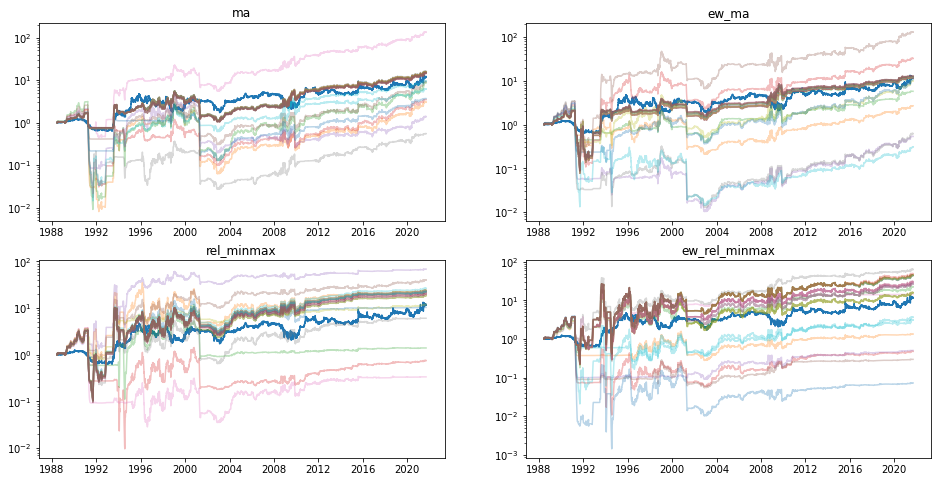

Saving INTG params...



----------------------------------------------------------------------
                                 ISRG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 121.04185421901627
Refitting current best...
Current best ma returns: 122.8555698958487
Fraction Invested: 0.994776332595273
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 124.55638250336106
Invested: 0.994776332595273
New best: 124.55730434064175
Invested: 0.994776332595273
New best: 124.54861946423644
Invested: 0.994776332595273
New best: 124.40005354169206
Invested: 0.994776332595273
New best: 124.40005354169206
Invested: 0.994776332595273
New best: 124.40042732364321
Invested: 0.994776332595273
New best: 124.39163324531107
Invested: 0.994776332595273
New best: 124.39639946145915
Invested: 0.994776332595273
New best: 124.44151744684228
In

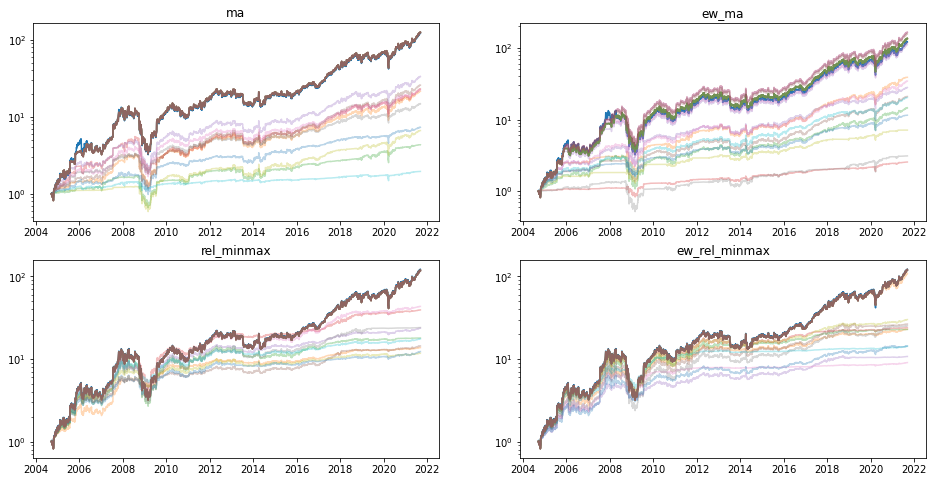

Saving ISRG params...



----------------------------------------------------------------------
                                 JD
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.7420567434580287
Refitting current best...
Current best ma returns: 2.7605728532753293
Fraction Invested: 0.9984988058019558
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.7515529527514766
Invested: 0.9984988058019558
New best: 2.7455710950564844
Invested: 0.9984988058019558
New best: 2.7459191014972752
Invested: 0.9984988058019558
New best: 2.7461799654417827
Invested: 0.9966433162152173
New best: 2.746113659897784
Invested: 0.9966433162152173
New best: 2.7431695353265897
Invested: 0.9966433162152173
New best: 2.906030695420249
Invested: 0.9966433162152173
New best: 2.9083267635324015
Invested: 0.9966433162152173
New best: 2.9083968210719

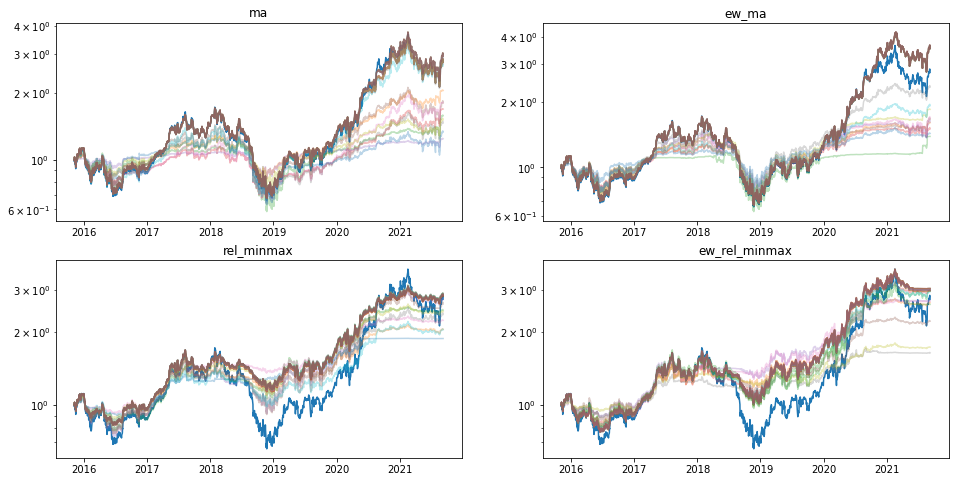

Saving JD params...



----------------------------------------------------------------------
                                 LULU
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 21.883484166824
Refitting current best...
Current best ma returns: 23.7489183786196
Fraction Invested: 0.9971571611333322
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 23.7489183786196
Invested: 0.9971571611333322
New best: 23.755024517363474
Invested: 0.9971571611333322
New best: 23.752574932467944
Invested: 0.9971571611333322
New best: 23.752578071151866
Invested: 0.9971571611333322
New best: 23.75381249820891
Invested: 0.9971571611333322
New best: 23.75347642950784
Invested: 0.9971571611333322
New best: 23.753465985226605
Invested: 0.9971571611333322
New best: 23.75283801474138
Invested: 0.9971571611333322
New best: 23.74940341798648
Inves

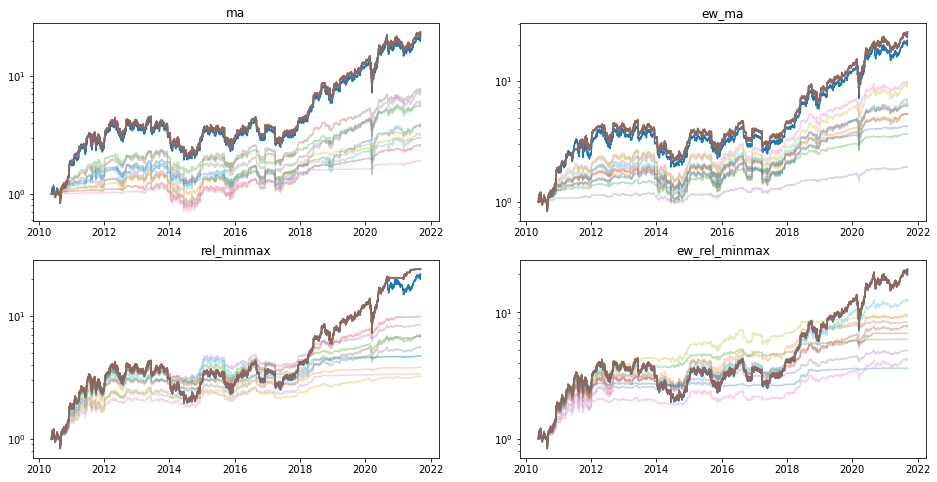

Saving LULU params...



----------------------------------------------------------------------
                                 LUV
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 75.78870359326851
Refitting current best...
Current best ma returns: 77.53118629926686
Fraction Invested: 0.9985763513519649
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 77.698166514159
Invested: 0.9985763513519649
New best: 77.69482816567725
Invested: 0.9985763513519649
New best: 77.5910579411738
Invested: 0.9985763513519649
New best: 79.41754057223743
Invested: 0.9985763513519649
New best: 81.14132850311299
Invested: 0.9985763513519649
New best: 81.08674807989824
Invested: 0.9985763513519649
New best: 81.06744909746604
Invested: 0.9985763513519649
New best: 81.06711892982099
Invested: 0.9985763513519649
New best: 79.8628315958384
Invested

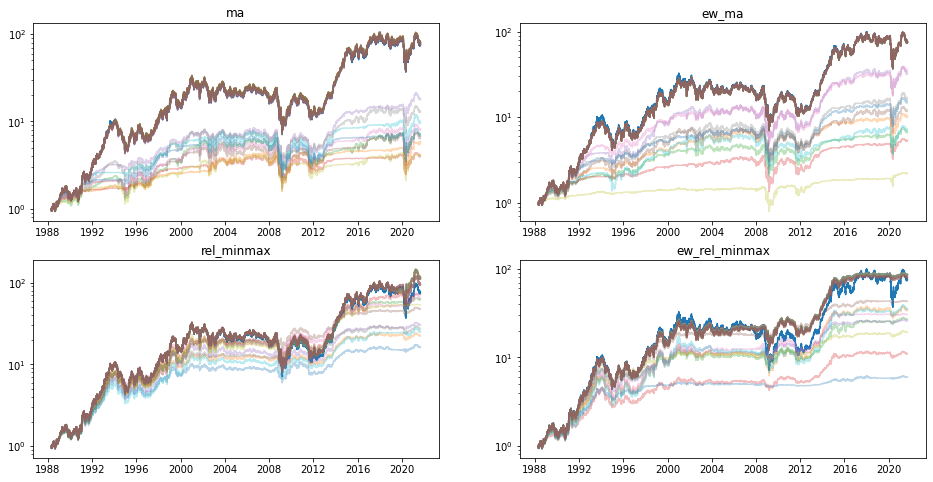

Saving LUV params...



----------------------------------------------------------------------
                                 MDB
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 8.777120445733729
Refitting current best...
Current best ma returns: 9.787981382637138
Fraction Invested: 0.07056707644589898
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 9.744103749823982
Invested: 0.07056707644589898
New best: 9.707275217459122
Invested: 0.07056707644589898
New best: 9.716043750855441
Invested: 0.07056707644589898
New best: 9.749467056475249
Invested: 0.07056707644589898
New best: 9.748866741154824
Invested: 0.07056707644589898
New best: 9.748866741154824
Invested: 0.07056707644589898
New best: 9.768023890468507
Invested: 0.07056707644589898
New best: 9.78444361191876
Invested: 0.07056707644589898
New best: 9.7338688980823

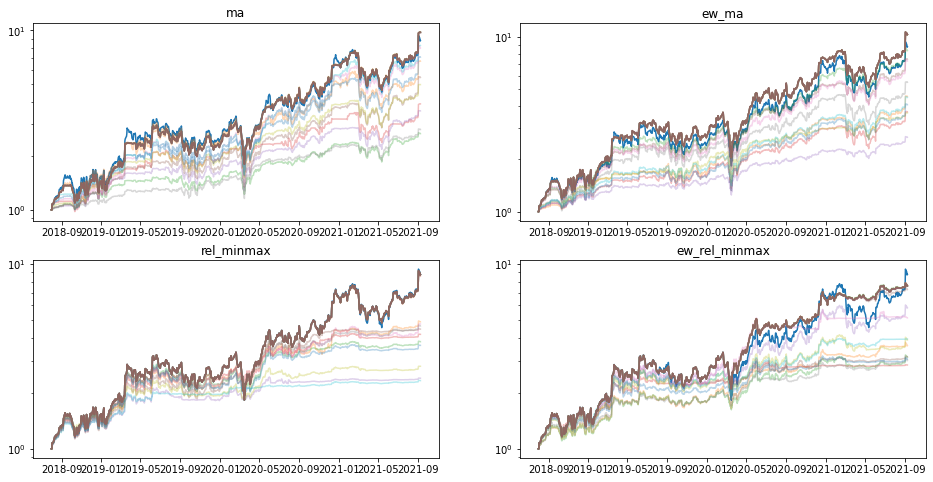

Saving MDB params...



----------------------------------------------------------------------
                                 MELI
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 35.96055970979521
Refitting current best...
Current best ma returns: 43.9542701268681
Fraction Invested: 0.9622577996973212
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 43.21615274593766
Invested: 0.9622577996973212
New best: 42.622533198566934
Invested: 0.9622577996973212
New best: 42.61752660109401
Invested: 0.9622577996973212
New best: 46.05293124966582
Invested: 0.9622577996973212
New best: 43.72150962571824
Invested: 0.8934198428498685
New best: 43.66634560457473
Invested: 0.8934198428498685
New best: 43.16779835734856
Invested: 0.8934198428498685
New best: 43.20896391408157
Invested: 0.8934198428498685
New best: 43.20219486823821
Inve

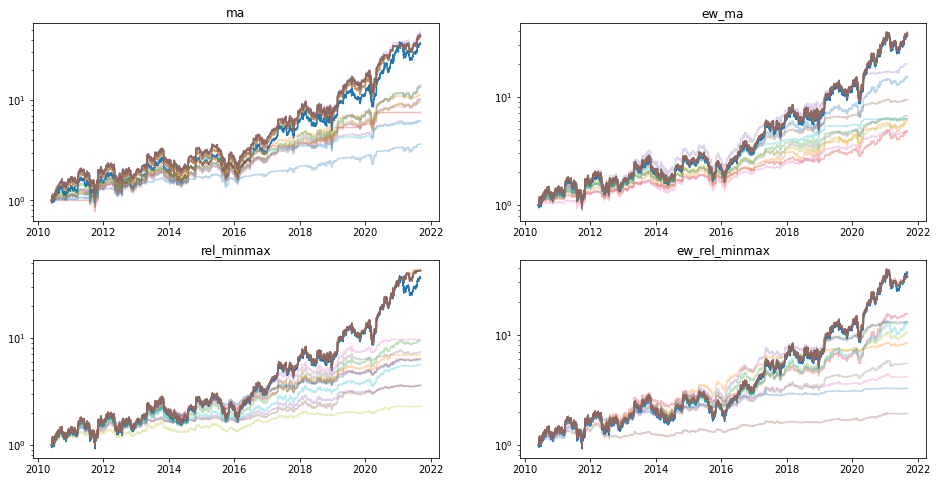

Saving MELI params...



----------------------------------------------------------------------
                                 MNST
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1233.27998046875
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1233.27998046875
Refitting current best...
Current best ew_ma returns: 1494.3603782183839
Fraction Invested: 0.9969062591691961
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 1498.4537252724276
Invested: 0.9969062591691961
New best: 1894.321222838485
Invested: 0.9969062591691961
New best: 1856.5279189272142
Invested: 0.9877075518400702
New best: 1856.3092539009258
Invested: 0.9877075518400702
New best: 1853

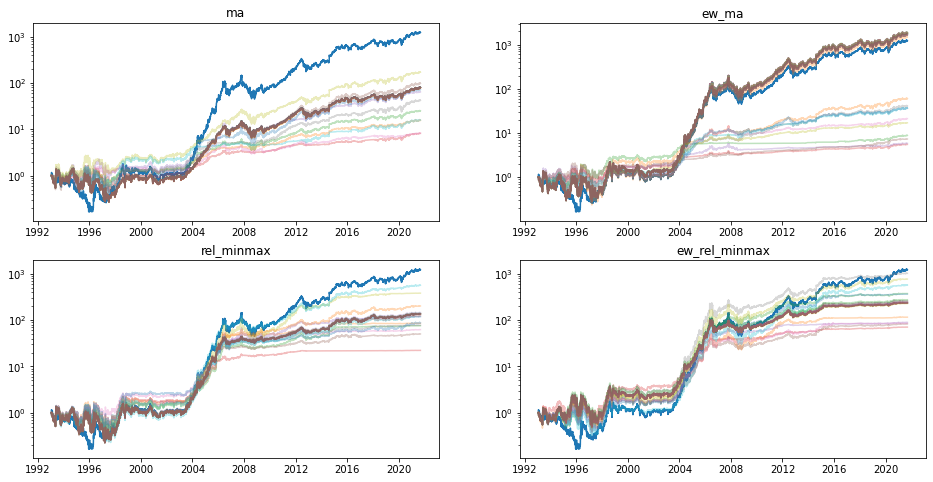

Saving MNST params...



----------------------------------------------------------------------
                                 MTCH
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 67.7162738036497
Refitting current best...
Current best ma returns: 79.09923397632856
Fraction Invested: 0.997774501565193
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 79.10057710988579
Invested: 0.997774501565193
New best: 79.09762439091612
Invested: 0.997774501565193
New best: 79.07784463417372
Invested: 0.997774501565193
New best: 79.07278349410623
Invested: 0.997774501565193
New best: 79.07278349410623
Invested: 0.997774501565193
New best: 79.06283162928057
Invested: 0.997774501565193
New best: 79.0705268789273
Invested: 0.997774501565193
New best: 79.0708344693584
Invested: 0.997774501565193
New best: 79.07156022776694
Invested: 0.997

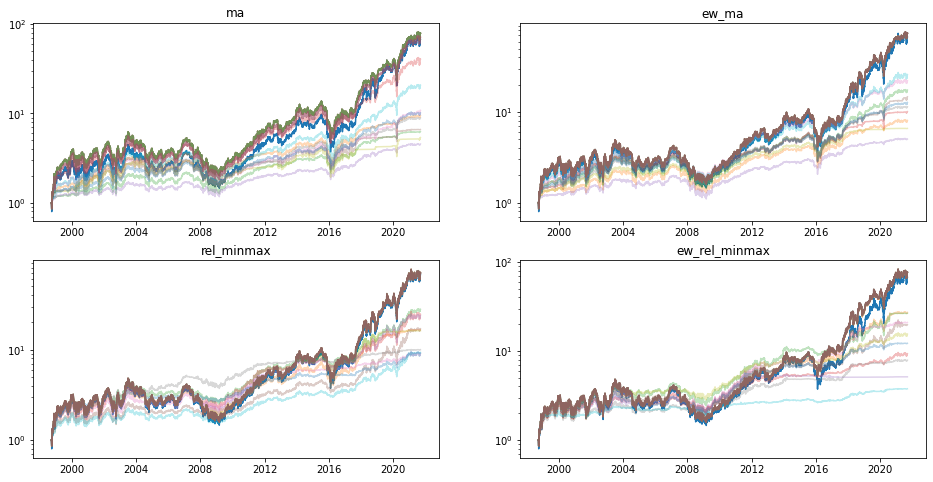

Saving MTCH params...



----------------------------------------------------------------------
                                 NVCR
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 16.607184650755343
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 16.607184650755343
Refitting current best...
Current best ew_ma returns: 21.40414721498822
Fraction Invested: 0.9999982135511748
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 21.405281526472752
Invested: 0.9999982135511748
New best: 19.526019810264827
Invested: 0.9999982135511748
New best: 19.525785864665806
Invested: 0.9999982135511748
New best: 19.527849506224914
Invested: 0.9999982135511748
New best: 

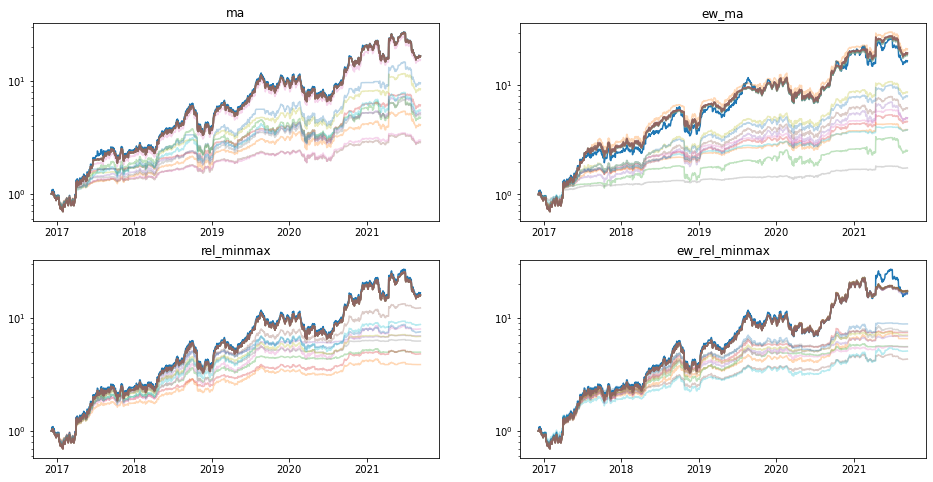

Saving NVCR params...



----------------------------------------------------------------------
                                 OKTA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.067904139594037
Refitting current best...
Current best ma returns: 7.413355333218847
Fraction Invested: 0.996776170522994
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 7.4134277846924395
Invested: 0.996776170522994
New best: 7.674619106772701
Invested: 0.996776170522994
New best: 7.663214897346606
Invested: 0.996776170522994
New best: 7.663214897346606
Invested: 0.996776170522994
New best: 7.656796159242969
Invested: 0.996776170522994
New best: 7.656623351242619
Invested: 0.996776170522994
New best: 7.656623351242619
Invested: 0.996776170522994
New best: 7.656552086126721
Invested: 0.996776170522994
New best: 7.6576407957971675
Invested: 

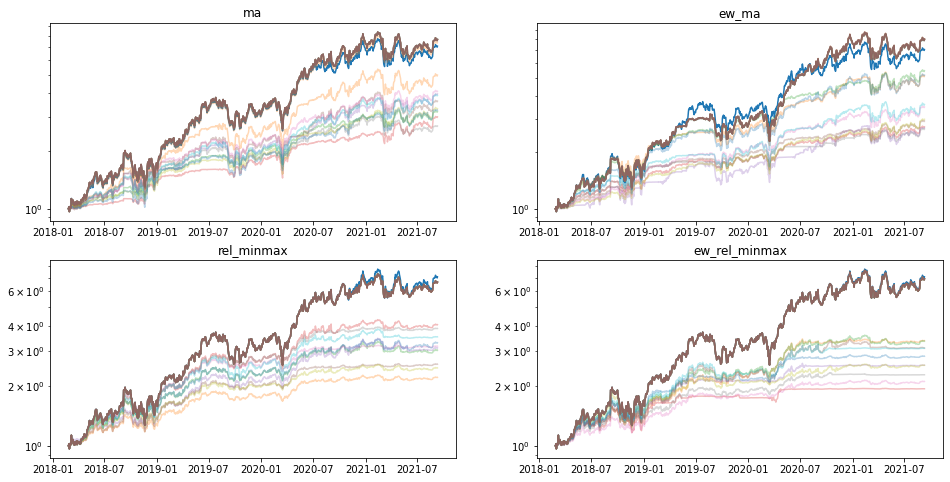

Saving OKTA params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 9.56886108250084
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 9.56886108250084
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 9.56886108250084
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_rel_minmax method...
-------------------

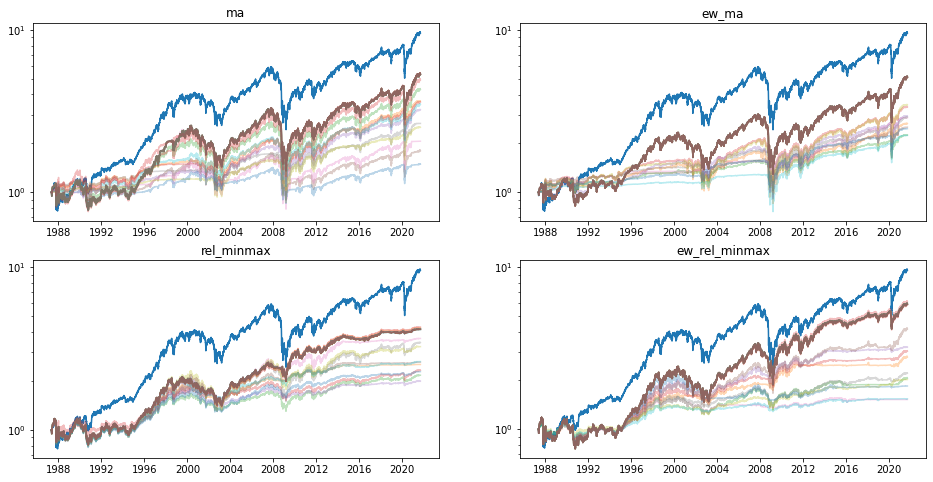

Saving ^NYA params...


In [14]:
N_RAND = 10
N_ADJ = 15

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [15]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [16]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


INTG:
  Best Return: 26.69390311615947 (ew_rel_minmax)
  25.50% in

ISRG:
  Best Return: 157.186568299846 (ew_ma)
  86.72% in

JD:
  Best Return: 3.535347717625792 (ew_ma)
  92.87% in

LULU:
  Best Return: 25.60345622678425 (ew_ma)
  99.32% in

LUV:
  Best Return: 96.07711776554807 (rel_minmax)
  80.89% in

MDB:
  Best Return: 10.350497330259785 (ew_ma)
  94.10% in

MELI:
  Best Return: 43.21344828964649 (ma)
  89.34% in

MNST:
  Best Return: 1686.4025791399638 (ew_ma)
  98.77% in

MTCH:
  Best Return: 76.87885645010473 (ew_rel_minmax)
  68.60% in

NVCR:
  Best Return: 19.639898558596485 (ew_ma)
  100.00% in

OKTA:
  Best Return: 7.993210900904263 (ew_ma)
  99.99% in

^NYA:
  Best Return: 9.56886108250084 (ma)
  100.00% in


In [17]:
!say qp is dunzo

IXIC: Nasdaq